In [ ]:
import pandas as pd
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.sql.types import *
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import matplotlib.pyplot as plt

In [ ]:
from machine_learning.testing import evaluateModel
from machine_learning.training import trainModel

In [ ]:
import pydoop.hdfs as hd

# **1. Load data**

In [ ]:
data_path = 'hdfs://node-master:8020/user/hadoop/WA_Fn-UseC_-HR-Employee-Attrition.csv'
schema_fields = []

In [ ]:
spark = SparkSession.builder.master("spark://node-master:7077").appName("Employee_Attrition").getOrCreate()

with hd.open(data_path) as f:
    data =  pd.read_csv(f)

2023-02-06 10:18:11,518 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
for col_index in range(data.shape[1]):
  field_name = data.columns[col_index]
  field_type = data.dtypes[col_index]

  if field_type == 'int64':
    schema_fields.append(
        StructField(field_name, FloatType(), nullable = True)
    )
  elif field_type == 'object':
        schema_fields.append(
        StructField(field_name, StringType(), nullable = True)
    )

df = spark.read.csv(path=data_path, schema= StructType(schema_fields)).cache()

23/02/06 10:18:20 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
df = spark.read.csv(path=data_path, schema= StructType(schema_fields)).cache()
df = df.where(df.EmployeeNumber.isNotNull())

df = df.where(df.EmployeeNumber.isNotNull())
df.show()

23/02/06 10:18:20 WARN CacheManager: Asked to cache already cached data.


23/02/06 10:18:36 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/02/06 10:18:51 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/02/06 10:19:06 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/02/06 10:19:21 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


23/02/06 10:19:36 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/02/06 10:19:51 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/02/06 10:20:06 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


+----+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
| Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBala

In [ ]:
discrete_attributes = ["NumCompaniesWorked", "TrainingTimesLastYear", ]
continous_attributes = ["Age", "DailyRate", "DistanceFromHome", "HourlyRate", "MonthlyIncome", 
                        "MonthlyRate", "PercentSalaryHike", "TotalWorkingYears",
                        "YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"]
categorical_attributes = ["Department", "EducationField", 
                          "Gender", "JobRole", "MaritalStatus"]
ordinal_attributes = ["BusinessTravel", "Education", "EnvironmentSatisfaction", "JobInvolvement", 
                      "JobLevel", "JobSatisfaction", "PerformanceRating",  "OverTime", 
                      "RelationshipSatisfaction", "StockOptionLevel",
                      "WorkLifeBalance"]
numeric_attributes = discrete_attributes + continous_attributes

target_name = "Attrition"

In [ ]:
df = df.drop(*['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'])

#**2. Decision Tree**

Split data to train and test, 80% is for training and the rest is for tesing.

In [ ]:
train, test = df.randomSplit([0.8, 0.2])

Define decision tree and its hyper parameters for grid searching.

In [ ]:
dt = DecisionTreeClassifier(featuresCol= 'features', labelCol = 'label')

dtParamGrid = ParamGridBuilder() \
    .addGrid(dt.minInstancesPerNode, [3, 5, 10, 15]) \
    .addGrid(dt.maxDepth, [3, 5, 10, 20]) \
    .addGrid(dt.maxBins, [8, 16, 32])\
    .build()

Using grid search to find best hyper parameter. The evaluation strategy is k-fold cross validation, in our case, k equals 5. In other words, each hyper parameters set is evaluated by 5-fold cross validation on traing data.  
The best model is tested on test data, results are following.

In [ ]:
bestDT = trainModel(train, dt, dtParamGrid)

Accuracy: 0.8086627847584023
Confusion matrix:
 [[222  33]
 [ 25  10]]
Precision: [0.89878543 0.23255814]
Recall: [0.87058824 0.28571429]


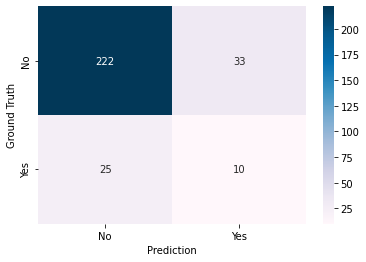

In [ ]:
acc, confusion, precision, reall = evaluateModel(test, bestDT)

fig, ax = plt.subplots(1, 1)
sns.heatmap(confusion, annot= True, cmap="PuBu", ax = ax, fmt= '.0f')
ax.set_xlabel("Prediction")
ax.set_ylabel("Ground Truth")
ax.set_yticklabels(["No", "Yes"])
ax.set_xticklabels(["No", "Yes"])

plt.show()

#**3. Random forest**

Similar to Decision Tree, deinfe random foreset and hyper parameters grid to find best model by 5-fold cross validation on training data.

In [ ]:
rf = RandomForestClassifier(featuresCol= 'features', labelCol = 'label')

rfParamGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 50, 100]) \
    .addGrid(rf.minInstancesPerNode, [3, 5, 10]) \
    .addGrid(dt.maxDepth, [3, 5, 10]) \
    .build()

Fit to training data and results are bellow. 

In [ ]:
rfModel = trainModel(train_data = train, mlModel= rf, paramGrid= rfParamGrid)

Accuracy: 0.853681576672207
Confusion matrix:
 [[255   0]
 [ 31   4]]
Precision: [0.89160839 1.        ]
Recall: [1.         0.11428571]


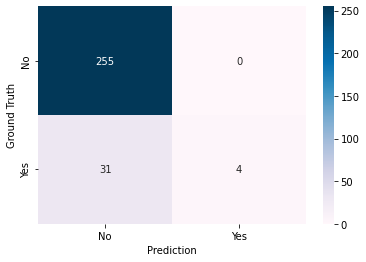

In [ ]:
acc, confusion, precision, recall = evaluateModel(test, rfModel)

fig, ax = plt.subplots(1, 1)
sns.heatmap(confusion, annot= True, cmap="PuBu", ax = ax, fmt= '.0f')
ax.set_xlabel("Prediction")
ax.set_ylabel("Ground Truth")
ax.set_xticklabels(["No", "Yes"])
ax.set_yticklabels(["No", "Yes"])

plt.show()